https://docs.pymc.io/notebooks/GLM-linear.html
https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal

In this post we study the Regularized Bayesian Regression model to explore the weight-space view of Gaussian Process Regression described in the book [Gaussian Processes for Machine Learning, Ch 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf). We follow this reference very closely. Our main objective is to ilustrate the concepts and results through a concrete example. We use [PyMC3](https://docs.pymc.io) to run bayesian sampling. See [this](https://juanitorduz.github.io/intro_pymc3/) post for an introduction to bayesian methods and PyMC3.

Let us consider the model:

$$
f(x) = x^T b \quad \text{and} \quad y = f(x) + \varepsilon, \quad \text{with} \quad \varepsilon \sim N(0, \sigma_n^2)
$$

where \\(x \in \mathbb{R}^d\\) is a vector of data and \\(b \in \mathbb{R}^d\\) is the vector of weights (parameters). We assume a bias weight is included in \\(b\\).  

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import pymc3 as pm

import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

## Generate Sample Data

Let us begin by generating sample data.

In [2]:
# Define dimension.
d = 2

# Number of samples. 
n = 100

# Independent variable. 
x = np.linspace(start=0, stop=1, num=n).reshape([1, n])

# Design matrix. We add a column of ones to account for the biad term. 
X = np.append(np.ones(n).reshape([1, n]), x, axis=0)

Now we generate the response variable.

In [4]:
# True parameters. 

b = np.zeros(d)
## Intercept. 
b[0] = 1
## Slope. 
b[1] = 3

b = b.reshape(d, 1)

# Error standar deviation. 
sigma_n = 0.5

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n).reshape([n, 1])

f = np.dot(X.T, b)

# Observer target variable. 
y = f + epsilon

We visualize the data set.

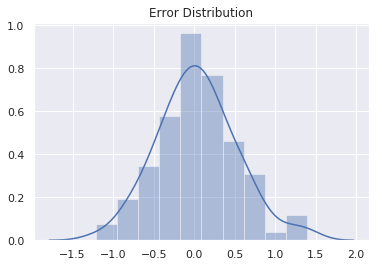

In [21]:
sns.distplot(epsilon).set_title("Error Distribution");

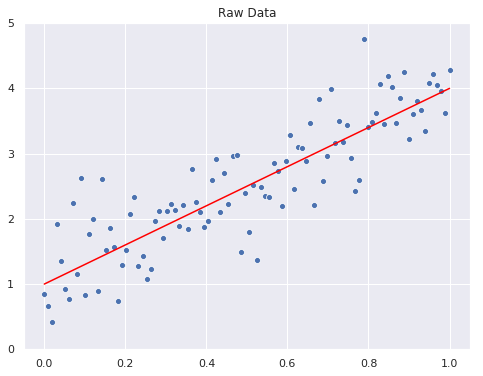

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
# Plot raw data.
sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));
# Plot "true" line fit.
sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color="red");

ax.set_ylim((0,5));
ax.set_title("Raw Data");

## Likehood

A straightforward calculation shows that the likehood function is given by

$$
p(y|X, b) = 
\frac{1}{(2\pi \sigma_n^2)^{n/2}} \exp\left(-\frac{1}{2\sigma_n^2}||y - X^T b||^2\right) = 
N(X^T b, \sigma_n^2 I)
$$

## Prior Distribution

We set a multivariate normal with mean zero distribution for the prior of the vector of weights \\(b \sim N(0, \Sigma_p)\\). Here \\(\Sigma_p \in M_{d}(\mathbb{R})\\) denotes the covariance matrix. 

In [22]:
# Mean vector.
mu_0 = np.zeros(d)
# Covariance matrix. 
sigma_p = np.array([[2, 1], [1, 2]]) + 1e-12*np.eye(d)

Let us sample from the prior distribution to see the level curves (see [here](https://juanitorduz.github.io/multivariate_normal/)). 

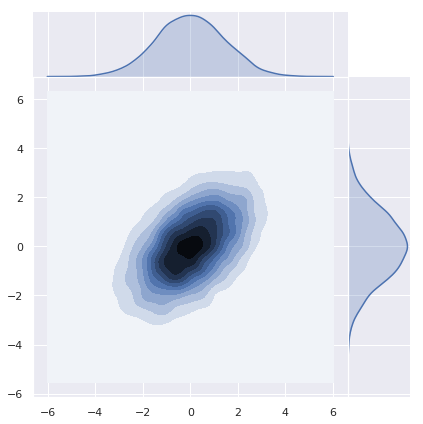

In [23]:
m = 10000

z = np.random.multivariate_normal(mean=mu_0, cov=sigma_p, size=m)

z = z.T

sns.jointplot(x=z[0],
              y=z[1], 
              kind="kde", 
              space=0);

Note that the ellipse-like level curves are rotated (with respect the natural axis) due the fact that \\(\Sigma_p\\) is not diagonal. 

## Posterior Distribution

Now we want to use the data to find the posterior destribution of the vector of weights. Recall that the posterior is obtained (from Bayes rule) by computing 

$$
\text{posterior} =
\frac{\text{likelihood × prior}}{\text{marginal likelihood}}
$$

Concretely, 

$$
p(b|y, X) = 
\frac{p(y|X, b)p(b)}{p(y|X)}
$$

The marginal likehood \\(p(y|X)\\), which is independent of \\(b\\), is calculated as 

$$
p(y|X) = \int p(y|X, b)p(b) db
$$

### MCMC Sampling with PyMC3

Recall that we do not need to compute \\(p(y|X)\\) since we can sample from the posterior distribution using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling. Again, see [this](https://juanitorduz.github.io/intro_pymc3/) for more details. 

In [25]:
import theano.tensor as tt

model = pm.Model()

with model:
    
    # Define prior.
    beta = pm.MvNormal("beta", mu=mu_0, cov=sigma_p, shape=d)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=tt.dot(X.T, beta), sd=sigma_n, observed=y.squeeze())
    
    # Consider 6000 draws and 3 chains.
    trace = pm.sample(draws=6000, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta]
Sampling 3 chains: 100%|██████████| 19500/19500 [00:11<00:00, 1660.17draws/s]
The acceptance probability does not match the target. It is 0.8877824153791699, but should be close to 0.8. Try to increase the number of tuning steps.


Let us visualize the posterior distributions. 

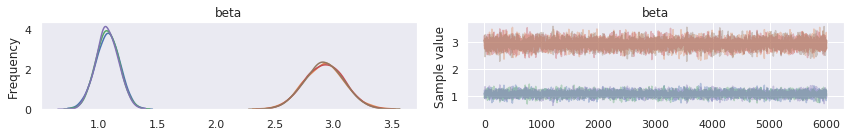

In [26]:
pm.traceplot(trace);

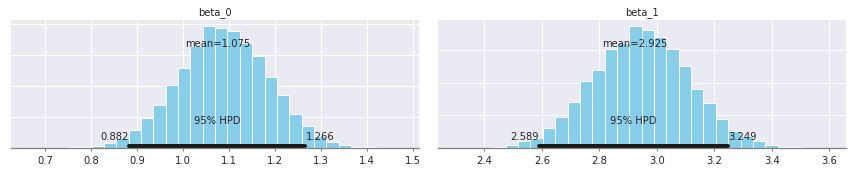

In [27]:
pm.plot_posterior(trace);

In [28]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,1.074521,0.098605,0.001411,0.881645,1.266410,5162.258160,0.999997
beta__1,2.925080,0.169324,0.002410,2.588636,3.249465,5219.634692,0.999952


In addition, let us see the join posterior distribution. 

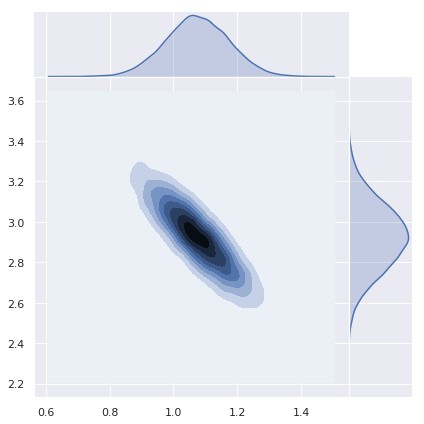

In [35]:
sns.jointplot(x=trace["beta"].T[0],
              y=trace["beta"].T[1], 
              kind="kde", 
              space=0);

### Analytical Solution

$$
p(b|y, X) \propto 
\exp\left(
-\frac{1}{2\sigma_n^2}||y - X^T b||^2
\right)
\exp\left(
-\frac{1}{2} b^T \Sigma_p b
\right)
$$

$$
A:= \sigma_n^{-2}XX^T + \Sigma_p^{-1} \in M_{d}(\mathbb{R})
\quad
\text{and}
\quad
\bar{b}:= \sigma_n^{-2}AXy
$$

Let us compute the analytic solution:

In [32]:
A = (sigma_n)**(-2)*np.dot(X, X.T) + np.linalg.inv(sigma_p)
A_inv = np.linalg.inv(A)

In [33]:
b_bar = (sigma_n)**(-2)*np.dot(A_inv, np.dot(X, y))
b_bar

array([[1.0744547],
       [2.92542  ]])

Note that these values coincide with the values above obtained from the MCMC sampling. Let us sample from the analytical solution of the posterior distribution.

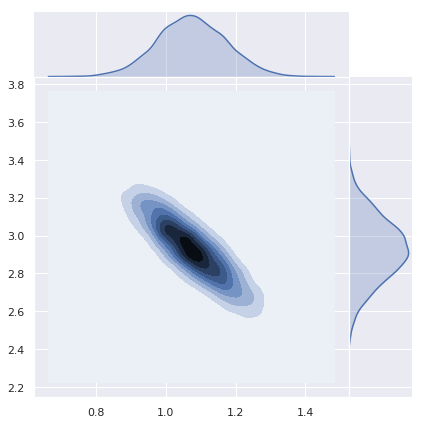

In [34]:
m = 10000

z = np.random.multivariate_normal(mean=b_bar.squeeze(), cov=A_inv, size=m)

z = z.T

sns.jointplot(x=z[0],
              y=z[1], 
              kind="kde", 
              space=0);

These level curves coinncide with the ones obtained above. 

## Predictions

### Parameter Mean

In [14]:
beta_hat = (np.apply_over_axes(func=np.mean, a=trace["beta"], axes=0)
            .squeeze()
            .reshape(d,1))

y_hat = np.dot(X.T, beta_hat)

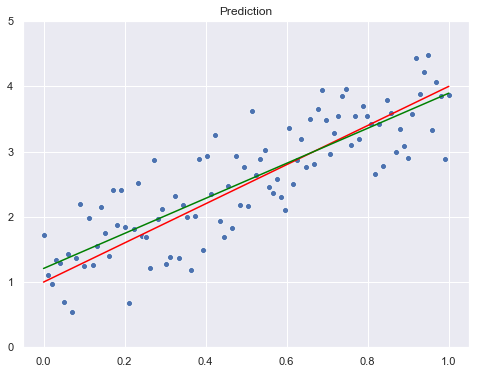

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color="red");

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

ax.set_ylim((0,5));
ax.set_title("Prediction");

### Confidence Inteval 

In [16]:
y_hat_samples = np.dot(X.T, trace["beta"].T)

In [17]:
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

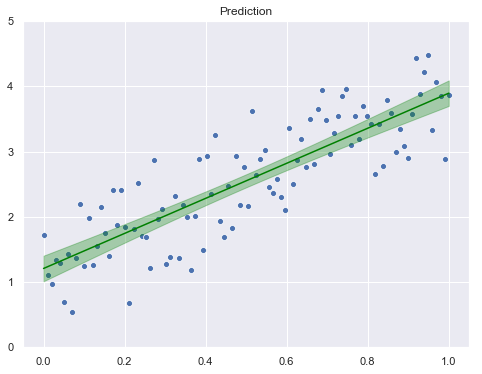

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

plt.fill_between(x=x.T.reshape(n,), 
                 y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
                 y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
                 color = "green", alpha = 0.3)

ax.set_ylim((0,5));
ax.set_title("Prediction");

### Test Set

In [19]:
def generate_prediction(x_star):

    prob = np.dot(x_star.T, trace["beta"].T)

    y_hat = np.random.choice(a=prob.squeeze())
    
    return y_hat

In [20]:
x_star = np.array([[1], [0.85]])

y_hat_star = generate_prediction(x_star)

y_hat_star

3.510333544438188

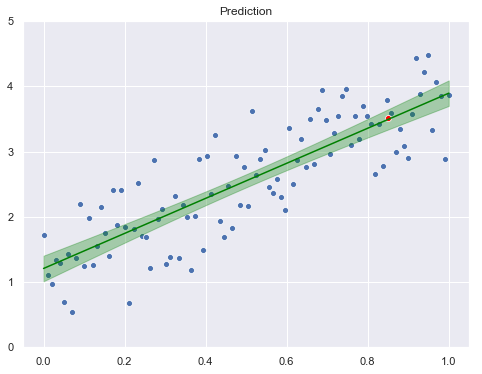

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,));

sns.lineplot(x=x.T.reshape(n,), y=y_hat.reshape(n,), color="green");

plt.fill_between(x=x.T.reshape(n,), 
                 y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
                 y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
                 color = "green", alpha = 0.3)

sns.scatterplot(x=x_star[1], y=y_hat_star, color="red");


ax.set_ylim((0,5));
ax.set_title("Prediction");